# Final Year Project General Notebook

In [1]:
import numpy as np
from numpy.linalg import inv, eig
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import test_mackeyglass
data = test_mackeyglass.test_mg().u

In [9]:
class Esn:
    
    # Initialise global variables at object creation
    def __init__(self,alpha=0.5,beta=10**-4,in_nodes=1,out_nodes=1,N=1000,rhoscale=1.25,Ttrain=2000,Twashout=100):
        np.random.seed(0)
        self.alpha = alpha
        self.beta = beta
        self.in_nodes = in_nodes
        self.out_nodes = out_nodes
        self.N = N
        #self.rhoscale = rhoscale
        self.x = np.zeros((N,1))
        self.Win = np.random.uniform(low=-0.5, high=0.5, size=(N,in_nodes+1))
        self.W = np.random.uniform(low=-1.5, high=1.5, size=(N,N))
        self.Wout = np.zeros(in_nodes+N+1)
        self.M = np.zeros((in_nodes+N+1,Ttrain-Twashout))
        self.Ttrain = Ttrain
        self.Twashout = Twashout
        # Complete scale factor for W
        eigv, _ = eig(self.W)                        # tuple containing eigen values + eigen vectors
        eigv_abs = [abs(k) for k in eigv]            # compute absolute eigen values
        eigv_abs.sort(reverse=True)                  # sort by largest
        self.rhoscale = rhoscale/eigv_abs[0]         # adjust rhoscale using largest eigen value
        self.W = self.W*rhoscale                     # scale spectral radius of W                                    
        
    # Contruct M matrix
    def train_M(self,data):
        for i in range(self.Twashout):
            self.x = (1-self.alpha)*self.x + self.alpha*np.tanh(self.Win@np.array([[1],[data[i]]])
                                                           + self.W@self.x)
        for i in range(self.Ttrain-self.Twashout):
            self.x = (1-self.alpha)*self.x + self.alpha*np.tanh(self.Win@np.array([[1],[data[i+self.Twashout]]])
                                                           + self.W@self.x)
            self.M[:,i] = np.concatenate((np.array([[1],[data[i+self.Twashout]]]),self.x))[:,0]
    
    # Train Wout (provided M first)
    def train_readouts(self,data):
        Mt = self.M.transpose()
        D = data[self.Twashout:self.Ttrain]
        self.Wout = D@Mt@inv(self.M@Mt + self.beta*np.identity(self.in_nodes+self.N+1))
    
    def train(self,data):
        self.train_M(data)
        self.train_readouts(data)
    
    # Test function given a starting data_point and test time
    # Returns predicted data array
    def test(self,data_point,test_time=1000):
        y = np.array([data_point])
        self.Y = np.zeros((self.out_nodes,test_time))
        for i in range(test_time):
            self.x = (1-self.alpha)*self.x + self.alpha*np.tanh(self.Win@np.array([[1],y]) + self.W@self.x)
            y = self.Wout@np.concatenate((np.array([[1],[y]]),self.x))
            self.Y[:,i] = y
        return self.Y

    # Can use this to plot predicted data with input data if you want
    # test_time needs to be the same at Ttrain at the moment
    def plot(self,correct_data):
        xs = np.linspace(1,self.Ttrain,self.Ttrain)
        ys = correct_data[:self.Ttrain]
        plt.plot(xs,self.Y[0,:],label="esn")
        plt.plot(xs,ys,label="input data")
        plt.legend()

In [ ]:
mean_squared_error(Y[0,:],data.u[:Ttrain])

mse: 0.5846464159563807


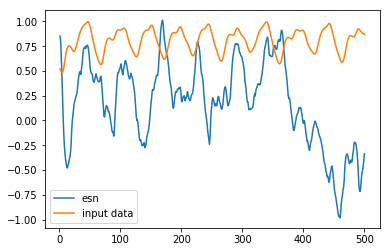

In [10]:
# Example code to run
esn = Esn(alpha=0.3,beta=0.001,Ttrain=500)
esn.train(data)
Ys = esn.test(data[0],test_time=500)
esn.plot(data)
print("mse:",mean_squared_error(Ys[0,:],data[:esn.Ttrain]))

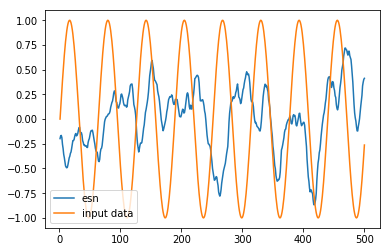

In [11]:
# Sin input
theta = np.linspace(0,50,500)
sintheta = np.sin(theta)

esn_sin = Esn(alpha=0.3,beta=0.001,Ttrain=500)
esn_sin.train(sintheta)
Ys = esn_sin.test(sintheta[0],test_time=500)
esn_sin.plot(sintheta)